# Preparing the environment


## Libraries

Use the requirements.txt or uncomment the following cell

In [1]:
#%pip install --upgrade pip
#%pip install pandas
#%pip install matplotlib
#%pip install plotly
#%pip install numpy
#%pip install statsmodels
#%pip install scipy
#%pip install scikit-learn
#%pip install nbformat
#%pip install fastparquet

In [2]:
# requirements
import matplotlib.pyplot as plt
from scripts.data_treatment import DataManager
from scripts.eda import EDA
import pandas as pd

# Dataset - TON IoT

#### Description

TON IoT is a dataset for Industrial IoT designed by UNSW for Artificial Intelligence training and tests. It contains data about sensors' telemetry, Operating Systems log and network traffic. The official dataset is available at https://research.unsw.edu.au/projects/toniot-datasets. For this study purpose, the network traffic datasets were used, since they comprise DoS and DDoS attack as well as normal traffic information. It was necessary to adapt the packet information to achieve an equivalent to endpoint assessment.

It was selected 6 from 23 csv from Processed Network dataset directory that contained DoS and DDoS attacks. These datasets all contain the necessary features for metric evaluation, such as timestamp, source IP, destination IP and destination port. Although the dataset contains HTTP headers, such as URI, there are a lot of missing values, being impractical for this work.

### 1 - Load dataset

Merging all the dataset resulted in single one with 6,000,000 entries.

In [3]:
files_codes = ['_8', '_9', '_10', '_11', '_12', '_13']
dm = DataManager(data_dir='../0-datasets/ToN_IoT/Processed_Network_dataset')
df_ton = dm.get_dataset(files_codes)
df_ton.shape

INFO: Found files (6): ['../0-datasets/ToN_IoT/Processed_Network_dataset\\Network_dataset_10.csv', '../0-datasets/ToN_IoT/Processed_Network_dataset\\Network_dataset_11.csv', '../0-datasets/ToN_IoT/Processed_Network_dataset\\Network_dataset_12.csv', '../0-datasets/ToN_IoT/Processed_Network_dataset\\Network_dataset_13.csv', '../0-datasets/ToN_IoT/Processed_Network_dataset\\Network_dataset_8.csv', '../0-datasets/ToN_IoT/Processed_Network_dataset\\Network_dataset_9.csv']


(6000000, 46)

In [4]:
df_ton.head(2)

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,1556145104,192.168.1.30,3050,192.168.1.194,3050,tcp,-,0.000074,0,0,...,0,0,-,-,-,-,-,-,1,dos
1,1556145104,192.168.1.30,3050,192.168.1.194,3050,tcp,-,0.000010,0,0,...,0,0,-,-,-,-,-,-,1,dos


Analyzing the loaded data, it was identified other attacks, that are not relevant for this proposal, so they were filtered.

In [5]:
df_ton['type'].unique()

<StringArray>
['dos', 'normal', 'injection', 'ddos', 'scanning']
Length: 5, dtype: str

In [6]:
df_ton['type'].value_counts()

type
dos          3375328
ddos         1638813
injection     452659
scanning      388262
normal        144938
Name: count, dtype: int64

In [7]:
df_ton_relevant = df_ton[df_ton['type'].isin(['ddos', 'dos', 'normal'])].copy()

### 2 - Selecting Features

The dataset contains 46 columns, but only 6 of them were selected by this study: ts, src_ip, dst_ip, dst_port, label, and type. They correspond respectively to timestamp, source IP, destination IP, destination port, a boolean value for attack, and the attack specification (i.e.: dos, ddos, normal).

In [8]:
df_ton_relevant.dtypes

ts                          int64
src_ip                        str
src_port                    int64
dst_ip                        str
dst_port                    int64
proto                         str
service                       str
duration                  float64
src_bytes                   int64
dst_bytes                   int64
conn_state                    str
missed_bytes                int64
src_pkts                    int64
src_ip_bytes                int64
dst_pkts                    int64
dst_ip_bytes                int64
dns_query                     str
dns_qclass                  int64
dns_qtype                   int64
dns_rcode                   int64
dns_AA                        str
dns_RD                        str
dns_RA                        str
dns_rejected                  str
ssl_version                   str
ssl_cipher                    str
ssl_resumed                   str
ssl_established               str
ssl_subject                   str
ssl_issuer    

Checking the http_uri column, it was noticed that most of the entries have this column filled with '-', so they were considered empty values. This pointed that an adaptation of destination IP and port should be done to achieve an endpoint.

In [9]:
df_ton_relevant['http_uri'].value_counts()

http_uri
-                    5154051
/                       4991
/dvwa/login.php-r         35
/listproducts.php          1
/dvwa/                     1
Name: count, dtype: int64

In [10]:
df_ton_relevant['http_uri'] = df_ton_relevant['http_uri'].replace('-', None)

#### Checking missing values

In [11]:
df_ton_relevant.isna().sum()

ts                              0
src_ip                          0
src_port                        0
dst_ip                          0
dst_port                        0
proto                           0
service                         0
duration                        0
src_bytes                       0
dst_bytes                       0
conn_state                      0
missed_bytes                    0
src_pkts                        0
src_ip_bytes                    0
dst_pkts                        0
dst_ip_bytes                    0
dns_query                       0
dns_qclass                      0
dns_qtype                       0
dns_rcode                       0
dns_AA                          0
dns_RD                          0
dns_RA                          0
dns_rejected                    0
ssl_version                     0
ssl_cipher                      0
ssl_resumed                     0
ssl_established                 0
ssl_subject                     0
ssl_issuer    

#### Final selection

In [12]:
dm.select_features(
    src_ip_col='src_ip',
    dst_ip_col='dst_ip',
    dst_port_col='dst_port',
    type_col='type',
    label_col='label',
    timestamp_col='ts'
)


### 3 - Data Wrangling

#### Formating columns

Checking ts column format, it was noticed that it is in seconds.

In [13]:
df_ton_relevant['ts'].head(5)

0    1556145104
1    1556145104
2    1556145104
3    1556145104
4    1556145104
Name: ts, dtype: int64

In [14]:
# checking for missing values
df_ton_relevant['ts'].isna().sum()

np.int64(0)

After the aforementioned observations, the necessary data treatment of was conducted to define an endpoint format and formatting the other columns.

In [15]:
df_formatted = dm.transform_features(df_ton_relevant)
df_formatted.head()

,address,endpoint,time_local,type,is_anomaly
4000015,172.17.0.5,192.168.1.190:53,2019-04-24 06:12:48,normal,0
4000083,192.168.1.180,192.168.1.190:53,2019-04-24 06:12:48,normal,0
4000527,192.168.1.169,224.0.0.252:5355,2019-04-24 06:12:48,normal,0
4000568,192.168.1.180,192.168.1.190:53,2019-04-24 06:12:48,normal,0
4000719,192.168.1.180,192.168.1.190:53,2019-04-24 06:12:48,normal,0


#### Filter endpoint events

Below it was checked the endpoints request rate. As can be seen, there is a lot of endpoints with high number of requests, but a threshold is necessary to filter the ones with few requests. The chosen threshold was 300, this reduces the total of endpoints and select those with reasonable quantity to perform the analysis.

In [16]:
counts = df_formatted['endpoint'].value_counts()
counts

endpoint
192.168.1.184:443    949612
192.168.1.1:53       237824
192.168.1.190:80     224810
192.168.1.194:80     147292
192.168.1.152:80      96397
                      ...  
157.56.116.52:53          1
184.84.238.33:53          1
204.61.216.33:53          1
8.253.92.27:53            1
8.27.81.27:53             1
Name: count, Length: 57910, dtype: int64

In [17]:
consistent_endpoints = counts[counts >= 300].index
len(consistent_endpoints)

25

In [18]:
df_consist_endpoints = df_formatted[df_formatted['endpoint'].isin(consistent_endpoints)]

### 4 - Exploratory data analysis (EDA)

#### Check request frequency

It can be noticed when plotting the request evolution by time that, globally, the attacks are not widespread in the interval. Attacks just happens after 12h on 24. This suggests that activity before that can be discarded, since it is not significant. This decreases the number of windows to be processed.

In [19]:
eda = EDA(df_consist_endpoints.copy())
eda.plot_global_request_rate('min')

In [20]:
eda.df = eda.df[(eda.df['time_local'] > '2019-04-24 12:00:00') & (eda.df['time_local'] < '2019-04-26 12:00:00')]

In [21]:
eda.plot_global_request_rate('min')

Checking each endpoint request rate, as can be seen by the plot below, we see that some endpoints do not have both types of traffic (i.e.: anomalous, normal), so it is necessary to discard endpoints that do not have at least some attack interval. Normality is not a requirement, since we can assume that no request is the normal traffic behavior.

plot_start: 2019-04-24 18:20:00


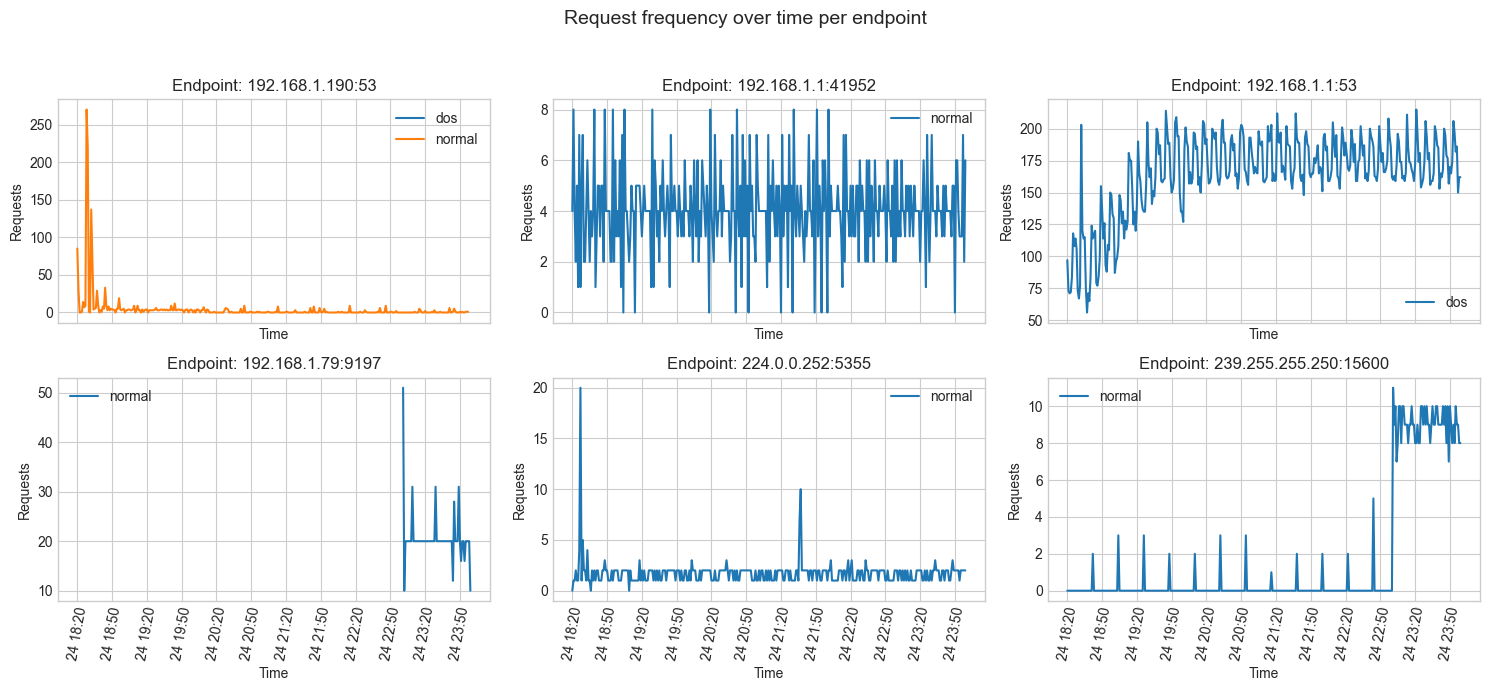

In [22]:
eda.plot_endpoint_request_rate()

Checking there are endpoints with no attacks:

In [23]:
eda.df[~eda.df['type'].isin(['dos', 'ddos'])]['endpoint'].unique()

<StringArray>
[     '224.0.0.251:5353',      '224.0.0.252:5355',  '239.255.255.250:1900',
     '192.168.1.1:41952',     '192.168.1.1:49152',    '192.168.1.195:5357',
     '192.168.1.255:138',            '8.8.8.8:53',      '192.168.1.190:53',
         '192.5.6.30:53',       '192.33.14.30:53',    '192.168.1.152:1880',
      '192.168.1.195:80', '239.255.255.250:15600',   '192.168.1.255:15600',
     '203.119.86.101:53',      '192.168.1.190:80',      '192.168.1.194:80',
      '192.168.1.184:80',      '192.168.1.152:80',     '192.168.1.184:443',
     '192.168.1.79:9197',     '192.168.1.79:7678',        '192.168.1.1:53']
Length: 24, dtype: str

Grouping requests by endpoint and is_anomaly, the count of endpoints with no anomaly (0) or with anomaly (1) are tabulated. That way is possible visualize endpoints that do not have any attack (NaN or 0) or few attacks.

In [24]:
g_endpoint_anom = eda.df.groupby(['endpoint','is_anomaly']).size().unstack(level='is_anomaly')
g_endpoint_anom

is_anomaly,0,1
endpoint,,
176.28.50.165:80,NaN,1927.0
192.168.1.152:1880,156.0,114.0
192.168.1.152:80,1736.0,94661.0
192.168.1.184:443,3402.0,946210.0
192.168.1.184:80,3.0,74890.0
192.168.1.190:53,5298.0,81.0
192.168.1.190:80,3329.0,221481.0
192.168.1.194:80,3354.0,143938.0
192.168.1.195:5357,777.0,101.0


To reduce the number of endpoints, a threshold = 1 was established for the total number of normal requests and anomalous requests. The presence of normal traffic was not considered restrictive, as idle endpoints, characterized by prolonged periods without traffic, can still represent valid normal behavior. The primary exclusion criterion was therefore the absence of attack traffic, since such endpoints do not contribute to the evaluation of anomaly detection performance. Although a single attack instance may appear insufficient, it was deliberately retained to assess the sensitivity of the proposed approach to low-intensity attack scenarios. After this filtering step, 16 endpoints with distinct behavioral profiles were retained, encompassing both idle and active normal traffic patterns.

In [25]:
has_clean_n_dirty_traffic = (g_endpoint_anom[0] >= 1) & (g_endpoint_anom[1] >= 1)
g_endpoint_anom[has_clean_n_dirty_traffic]

is_anomaly,0,1
endpoint,,
192.168.1.152:1880,156.0,114.0
192.168.1.152:80,1736.0,94661.0
192.168.1.184:443,3402.0,946210.0
192.168.1.184:80,3.0,74890.0
192.168.1.190:53,5298.0,81.0
192.168.1.190:80,3329.0,221481.0
192.168.1.194:80,3354.0,143938.0
192.168.1.195:5357,777.0,101.0
192.168.1.195:80,54.0,2033.0


In [26]:
valid_endpoints = g_endpoint_anom[has_clean_n_dirty_traffic].index.to_list()
len(valid_endpoints)

10

Below, it is plotted the top 10 valid endpoints that were selected by the filter.

In [27]:
valid_endpoints[:9]

['192.168.1.152:1880',
 '192.168.1.152:80',
 '192.168.1.184:443',
 '192.168.1.184:80',
 '192.168.1.190:53',
 '192.168.1.190:80',
 '192.168.1.194:80',
 '192.168.1.195:5357',
 '192.168.1.195:80']

plot_start: 2019-04-24 18:16:00


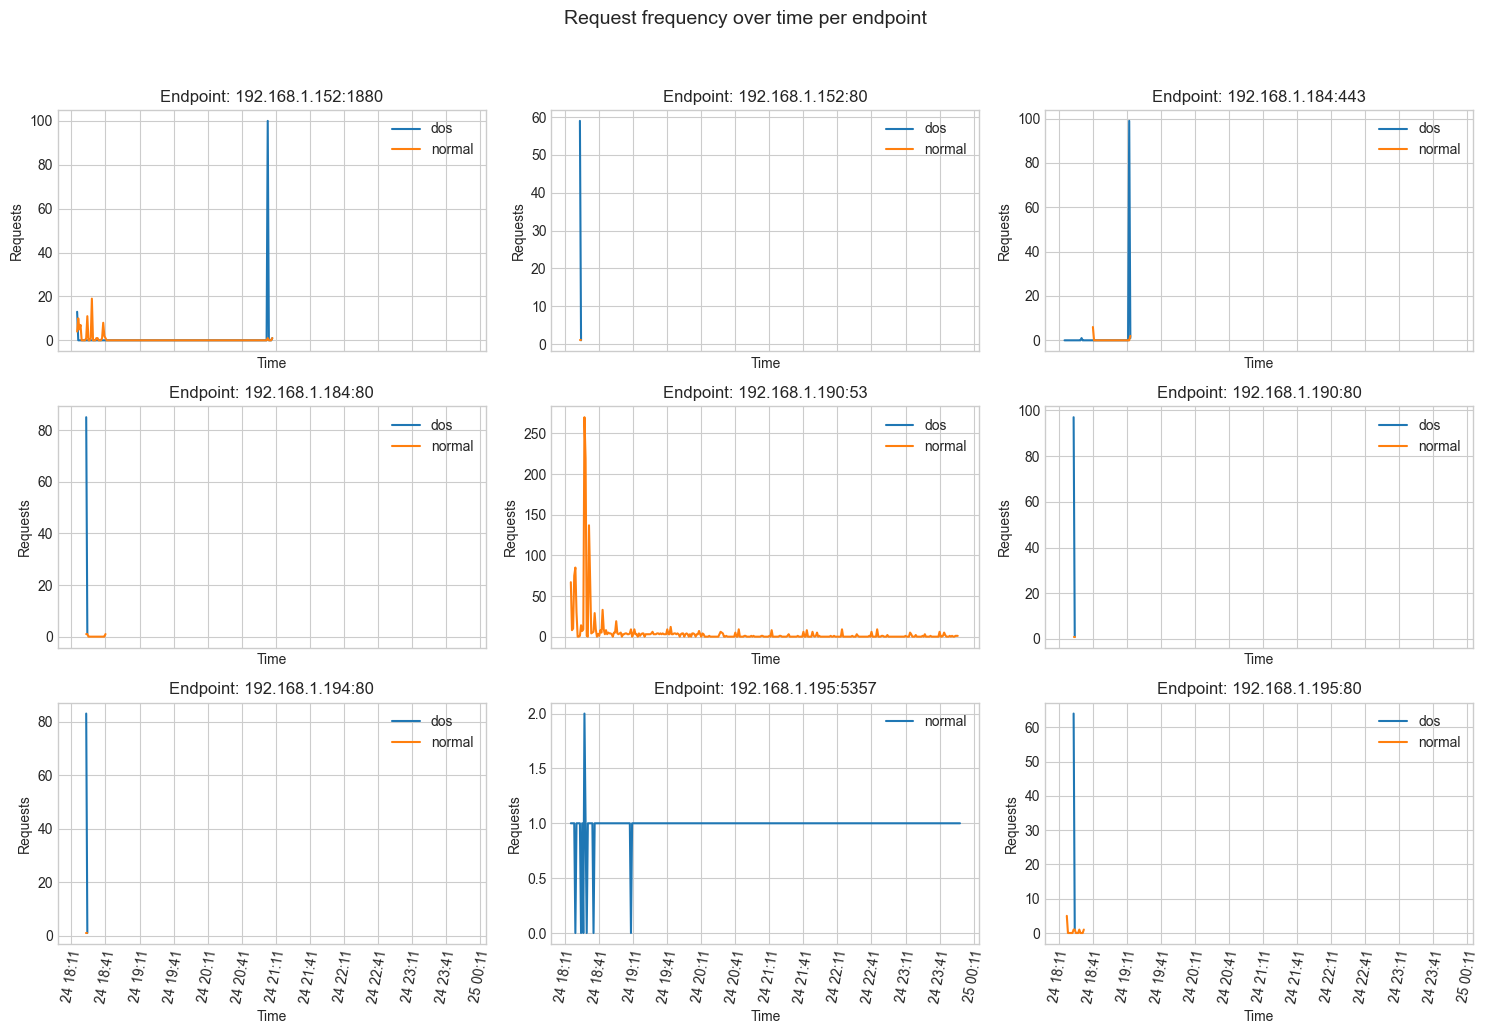

In [28]:
eda.plot_endpoint_request_rate(valid_uris=valid_endpoints[:9])

In [29]:
df_valid_endpoints = eda.df[eda.df['endpoint'].isin(valid_endpoints)]

After selecting the valid endpoint, they are encoded the format Endpoint i to facilitate the analysis

In [30]:
df_valid_endpoints = eda.encode_endpoint(df_valid_endpoints)

In [31]:
df_valid_endpoints.head()

,address,endpoint,time_local,type,is_anomaly
4389448,192.168.1.31,Endpoint 1,2019-04-24 18:13:44,dos,1
4389443,192.168.1.31,Endpoint 1,2019-04-24 18:13:44,dos,1
4389445,192.168.1.31,Endpoint 1,2019-04-24 18:13:44,dos,1
4389449,192.168.1.30,Endpoint 1,2019-04-24 18:13:45,dos,1
4389453,192.168.1.30,Endpoint 1,2019-04-24 18:13:45,dos,1


Although we filtered the endpoints with few events, these events start in different time interval, with no continuity. To simulated a environment where the traffic measurement is done in real-time, the endpoints must be in the same time interval. So for each endpoint, the missing intervals were filled with zero requests.

In [32]:
normal_traffic_df = df_valid_endpoints[df_valid_endpoints['is_anomaly'] != 1]

In [33]:
t_min = df_valid_endpoints[eda.time_col].min().floor("1s") - pd.to_timedelta(10, unit='m')
t_max = df_valid_endpoints[eda.time_col].max().ceil("1s") + pd.to_timedelta(10, unit='m')
print("Min:", t_min)
print("Max:", t_max)

count_rate_df = eda.adjust_endpoints_time_interval(df_valid_endpoints, t_min, t_max)
normal_traffic_rate_df = eda.adjust_endpoints_time_interval(normal_traffic_df, t_min, t_max)

Min: 2019-04-24 18:03:44
Max: 2019-04-25 20:09:08


In [34]:
count_rate_df.to_csv('outputs/treated_dataset/ton_treated_test.csv', index=False)
normal_traffic_rate_df.to_csv('outputs/treated_dataset/ton_treated_train.csv', index=False)

In [35]:
count_rate_df.shape

(939250, 4)

### 5 - Poisson Model Analysis

In [36]:
WINDOW_SIZES = [30, 60, 120, 300]

#### Checking window size

Now, we are interested in verifying different window frames for attack detection. As plotted below, three time frames were analyzed, and presented different granularity to extract metrics.

In [37]:
eda.df=df_valid_endpoints
eda.df.head()

,address,endpoint,time_local,type,is_anomaly
4389448,192.168.1.31,Endpoint 1,2019-04-24 18:13:44,dos,1
4389443,192.168.1.31,Endpoint 1,2019-04-24 18:13:44,dos,1
4389445,192.168.1.31,Endpoint 1,2019-04-24 18:13:44,dos,1
4389449,192.168.1.30,Endpoint 1,2019-04-24 18:13:45,dos,1
4389453,192.168.1.30,Endpoint 1,2019-04-24 18:13:45,dos,1


plot_start: 2019-04-24 18:13:44


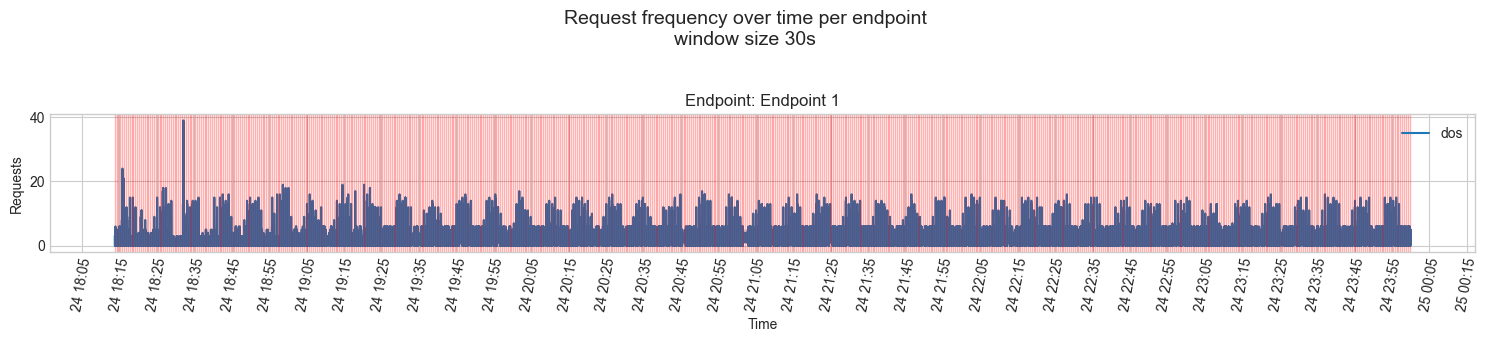

plot_start: 2019-04-24 18:13:44


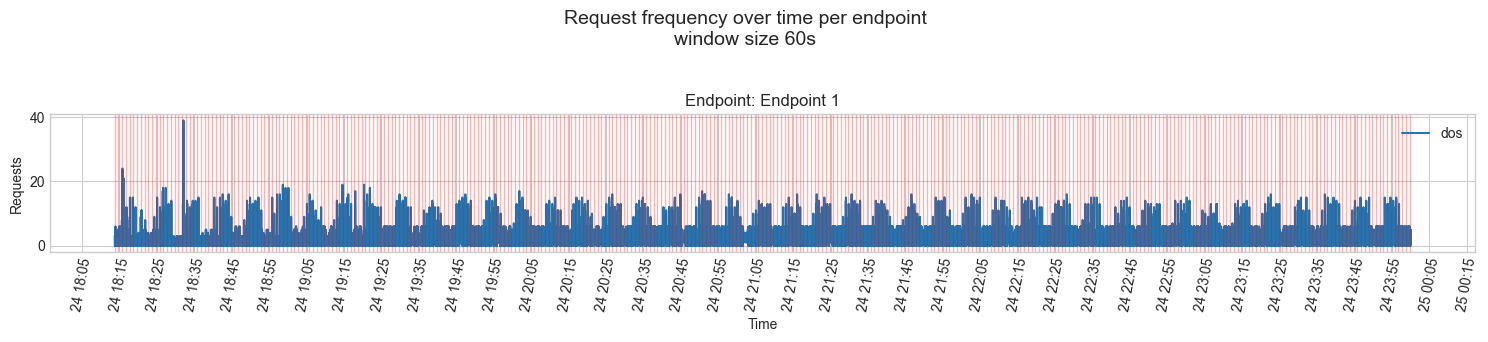

plot_start: 2019-04-24 18:13:44


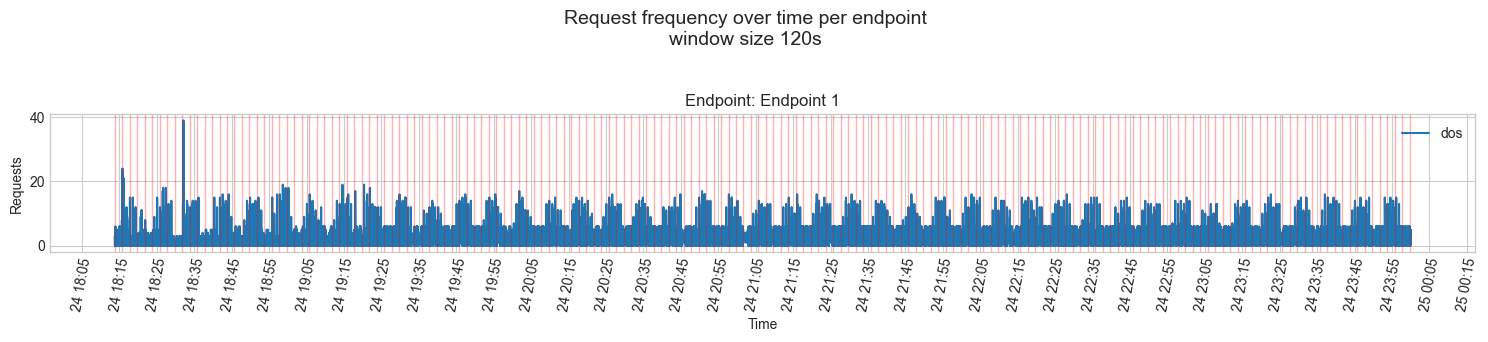

plot_start: 2019-04-24 18:13:44


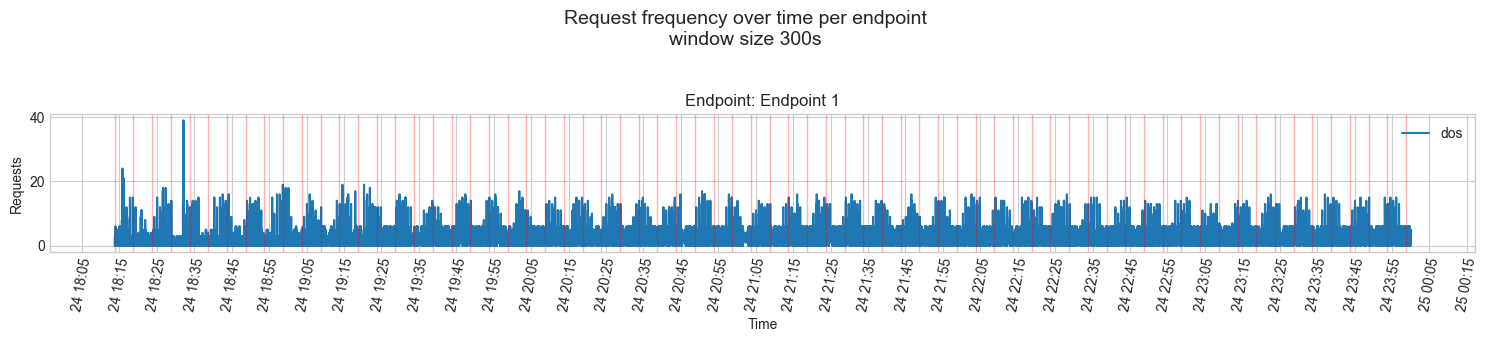

In [38]:
sample_endpoint = 'Endpoint 1'

for ws in WINDOW_SIZES:
    eda.plot_endpoint_request_rate(valid_uris=[sample_endpoint], frequency='1s', top=1, window_size=f'{ws}s', start_offset_s=0, interval=10)


#### Checking Poisson Fit for Single Sample

With the selected window sizes, below we check if there is variations in Poisson modeling assumption for different window sizes using one sample.

In [39]:
sample_rate = count_rate_df[count_rate_df["endpoint"] == sample_endpoint].copy()
sample_rate

,endpoint,time_local,total_requests,is_anomaly
0,Endpoint 1,2019-04-24 18:03:44,0,0
1,Endpoint 1,2019-04-24 18:03:45,0,0
2,Endpoint 1,2019-04-24 18:03:46,0,0
3,Endpoint 1,2019-04-24 18:03:47,0,0
4,Endpoint 1,2019-04-24 18:03:48,0,0
...,...,...,...,...
93920,Endpoint 1,2019-04-25 20:09:04,0,0
93921,Endpoint 1,2019-04-25 20:09:05,0,0
93922,Endpoint 1,2019-04-25 20:09:06,0,0
93923,Endpoint 1,2019-04-25 20:09:07,0,0


By indexing the windows, it is verified each window fit with Poisson modeling using well-known plots such as histogram, ECDF vs CDF and Q-Q plot. The objective is checking if window variation changes impact model suitability. As it can be seen in the sample below, variations in model suitability are noticed when window size is varied from 30s to 300s.

Window Size 30:
λ (mean) = 3.50
variance = 9.43
var / mean = 2.69


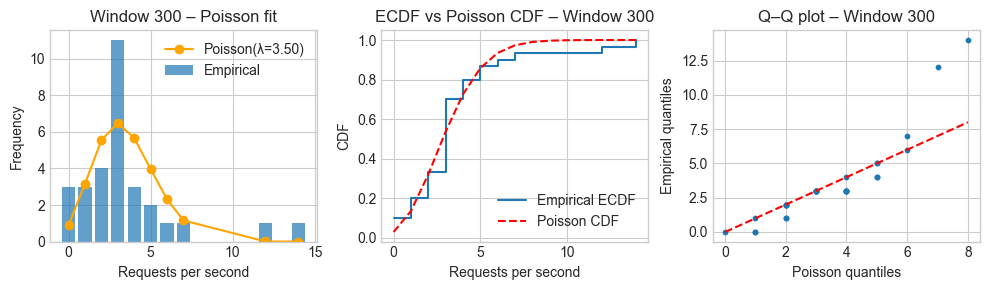

Window Size 60:
λ (mean) = 2.65
variance = 3.79
var / mean = 1.43


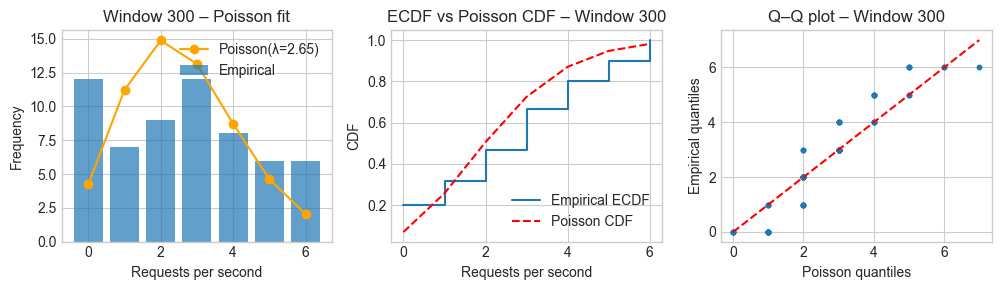

Window Size 120:
λ (mean) = 0.00
variance = 0.00


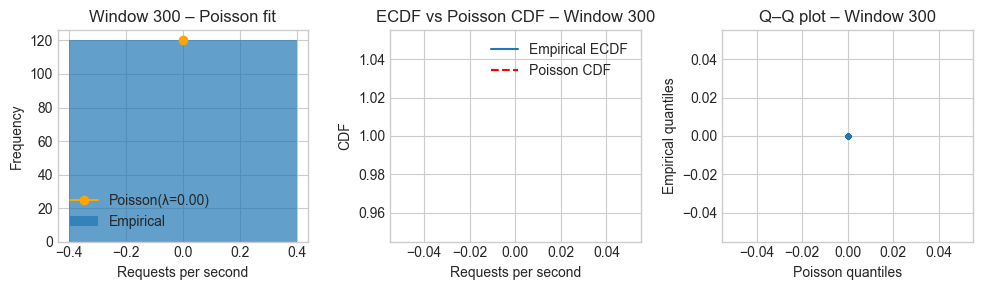

Window Size 300:
λ (mean) = 11.90
variance = 290.33
var / mean = 24.40


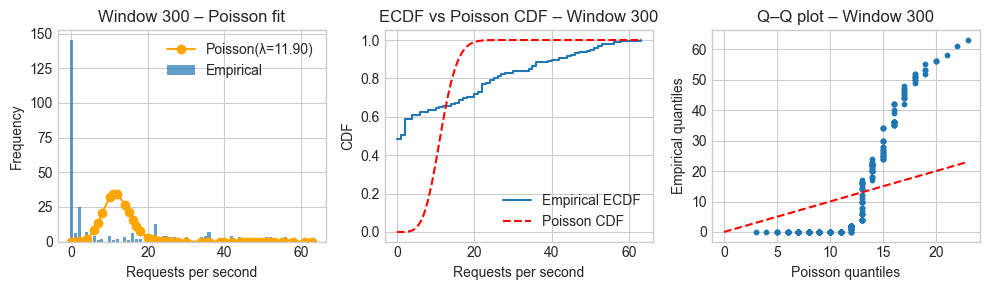

In [40]:
for window in WINDOW_SIZES:
    print(f'Window Size {window}:')
    sample_rate2 = sample_rate.copy()
    sample_rate2['window_start'] = sample_rate['time_local'].dt.floor(f'{window}s').copy()
    sample_rate2['window_id'] = (
        sample_rate2['window_start']
        .astype(int)
        .rank(method='dense')
        .astype(int) - 1
    )
    sample_rate2 = sample_rate2[['endpoint', 'window_id', 'time_local', 'total_requests']]
    eda.plot_poisson_diagnostic(sample_rate2, 300)

#### Checking Model Assumption for Whole Samples

This step is intended to assess the Poisson modeling suitability for the dataset. To assess this assumption, the time interval for each endpoint was grouped in windows of 30s, 60s, and 300s. Then, it was calculated each window variance and mean. To be a valid Poisson model, the $var(x) \approx E[x]$, which means that $\frac{var(x)}{E[x]} \approx 1$. So, the closer to 1 the ratio of each sample is, the more suitable the model is to be a valid reference. As a result, it can be seen that most of the endpoints follow the assumption that the change in model suitability is noticed mostly for endpoints with a high presence of anomaly. This validates the assumption that Poisson is a reasonable reference for normal traffic. The table also shows that the suitability is sensitive to window size; larger windows tend to be worse than smaller ones. This can be explained by the assumption of independence only being valid for local approximation.

In [41]:
window_sizes = [f'{w}s' for w in WINDOW_SIZES]
all_endpoint_df = count_rate_df.copy()
endpoint_poisson_stat = eda.poisson_evaluation_per_endpoint(all_endpoint_df, window_sizes)
endpoint_poisson_stat

,endpoint,var_mean_median_30s,n_anomaly_windows_30s,n_windows_30s,var_mean_median_60s,n_anomaly_windows_60s,n_windows_60s,var_mean_median_120s,n_anomaly_windows_120s,n_windows_120s,var_mean_median_300s,n_anomaly_windows_300s,n_windows_300s
0,Endpoint 1,2.514778,1654.0,3132,2.756820,829.0,1567,2.655462,416.0,784,2.590116,168.0,314
1,Endpoint 10,15.816891,544.0,3132,20.374092,309.0,1567,28.006325,157.0,784,30.642268,65.0,314
2,Endpoint 2,1.000000,2.0,3132,1.000000,2.0,1567,0.991597,2.0,784,0.986622,2.0,314
3,Endpoint 3,1.000000,1.0,3132,1.606693,1.0,1567,1.813926,1.0,784,1.838383,1.0,314
4,Endpoint 4,58.131510,624.0,3132,66.854179,315.0,1567,65.563727,160.0,784,64.615283,66.0,314
5,Endpoint 5,1.448276,4.0,3132,1.644068,3.0,1567,2.974790,3.0,784,2.326087,3.0,314
6,Endpoint 6,1.100079,11.0,3132,1.440678,7.0,1567,1.299853,4.0,784,1.789298,4.0,314
7,Endpoint 7,11.627949,619.0,3132,28.600363,313.0,1567,54.523799,157.0,784,71.484625,65.0,314
8,Endpoint 8,10.251093,621.0,3132,10.537051,313.0,1567,11.041892,157.0,784,11.259781,65.0,314
9,Endpoint 9,2.686657,622.0,3132,2.777859,313.0,1567,3.001446,157.0,784,3.097190,65.0,314


To inforce the findings, below we perform the analysis only in normal traffic. As it can be seen, the modeling adjust very well for 30s window.

In [42]:
endpoint_no_attack_poisson_stat = eda.poisson_evaluation_per_endpoint(normal_traffic_rate_df, window_sizes)
endpoint_no_attack_poisson_stat

,endpoint,var_mean_median_30s,n_anomaly_windows_30s,n_windows_30s,var_mean_median_60s,n_anomaly_windows_60s,n_windows_60s,var_mean_median_120s,n_anomaly_windows_120s,n_windows_120s,var_mean_median_300s,n_anomaly_windows_300s,n_windows_300s
0,Endpoint 1,2.000000,0.0,3132,2.000000,0.0,1567,2.000000,0.0,784,2.000000,0.0,314
1,Endpoint 10,0.431034,0.0,3132,0.406700,0.0,1567,0.464052,0.0,784,0.570657,0.0,314
2,Endpoint 2,1.000000,0.0,3132,1.000000,0.0,1567,0.991597,0.0,784,0.986622,0.0,314
3,Endpoint 3,1.000000,0.0,3132,1.606693,0.0,1567,1.813926,0.0,784,1.838383,0.0,314
4,Endpoint 4,0.507230,0.0,3132,0.520548,0.0,1567,0.647650,0.0,784,0.810108,0.0,314
5,Endpoint 5,1.000000,0.0,3132,1.000000,0.0,1567,2.475390,0.0,784,1.662207,0.0,314
6,Endpoint 6,1.000000,0.0,3132,1.000000,0.0,1567,1.000000,0.0,784,1.000000,0.0,314
7,Endpoint 7,0.510998,0.0,3132,0.570161,0.0,1567,0.585772,0.0,784,0.908425,0.0,314
8,Endpoint 8,0.482759,0.0,3132,0.512911,0.0,1567,0.581378,0.0,784,0.847170,0.0,314
9,Endpoint 9,1.000000,0.0,3132,1.000000,0.0,1567,0.995798,0.0,784,1.000000,0.0,314


In [43]:
def calculates_score_per_window_size(df, window_size):
    print(f'Median endpoints score for {window_size}s window size:', df[f'var_mean_median_{window_size}s'].median())

In [44]:
for window_size in WINDOW_SIZES:
    calculates_score_per_window_size(endpoint_poisson_stat, window_size)

Median endpoints score for 30s window size: 2.60071749839366
Median endpoints score for 60s window size: 2.7673391194972297
Median endpoints score for 120s window size: 2.988118179933287
Median endpoints score for 300s window size: 2.8436527178702553


In [45]:
for window_size in WINDOW_SIZES:
    calculates_score_per_window_size(endpoint_no_attack_poisson_stat, window_size)

Median endpoints score for 30s window size: 0.9999999999999997
Median endpoints score for 60s window size: 1.0000000000000002
Median endpoints score for 120s window size: 0.9936974789915968
Median endpoints score for 300s window size: 0.9933110367892977


In [46]:
def calculates_frac_anomaly(df, window_size):
    df[f"frac_anomaly_{window_size}s"]  = df[f"n_anomaly_windows_{window_size}s"]  / df[f"n_windows_{window_size}s"]

In [47]:
def plot_sorted(x, y, label):
    order = x.argsort()
    plt.plot(
        x.iloc[order],
        y.iloc[order],
        marker="o",
        linestyle="-",
        label=label
    )


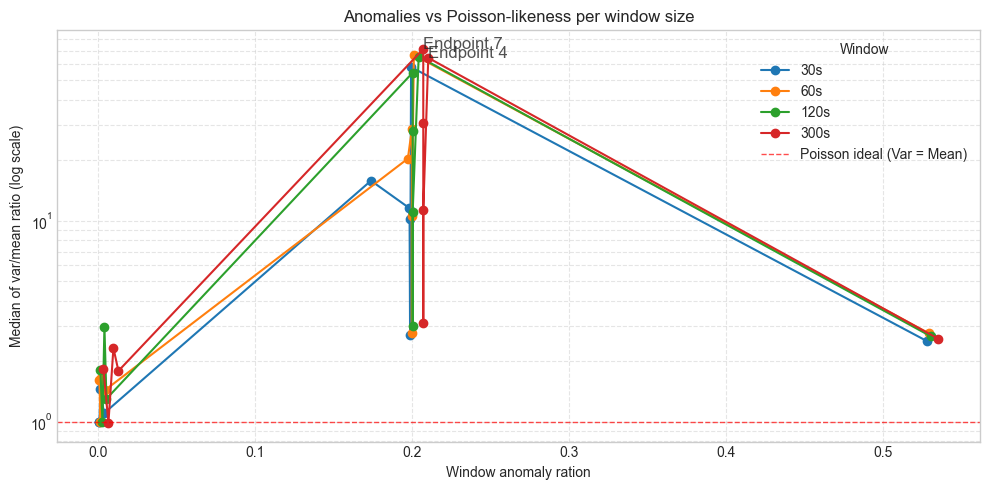

In [48]:
df = endpoint_poisson_stat.copy()
plt.figure(figsize=(10,5))

for window_size in WINDOW_SIZES:
    calculates_frac_anomaly(df, window_size)
    plot_sorted(
        df[f"frac_anomaly_{window_size}s"],
        df[f"var_mean_median_{window_size}s"],
        f"{window_size}s"
    )

plt.axhline(
    1.0,
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    color='red',
    label="Poisson ideal (Var = Mean)"
)

plt.yscale("log")
plt.xlabel("Window anomaly ration")
plt.ylabel("Median of var/mean ratio (log scale)")
plt.title("Anomalies vs Poisson-likeness per window size")

top_outliers = df.nlargest(2, "var_mean_median_300s")
for _, row in top_outliers.iterrows():
    plt.text(
        row["frac_anomaly_300s"],
        row["var_mean_median_300s"],
        row["endpoint"],
        fontsize=12,
        alpha=0.8
    )


plt.legend(title="Window")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("outputs/poisson-likeness.png")
plt.show()


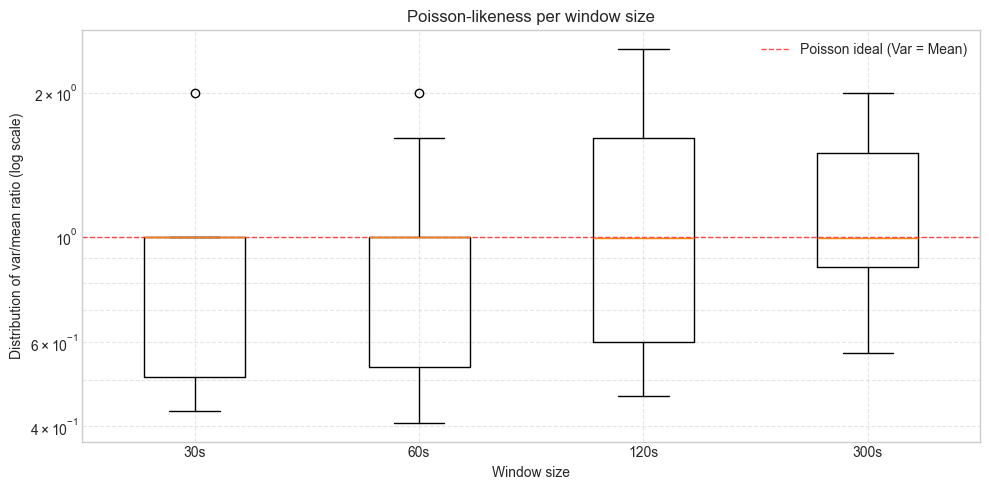

In [49]:
df = endpoint_no_attack_poisson_stat.copy()
plt.figure(figsize=(10, 5))

data = [
    df[f"var_mean_median_{window_size}s"].dropna()
    for window_size in WINDOW_SIZES
]

labels = [f"{window_size}s" for window_size in WINDOW_SIZES]

plt.boxplot(
    data,
    tick_labels=labels,
    showfliers=True
)

# Poisson line reference
plt.axhline(
    1.0,
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    color="red",
    label="Poisson ideal (Var = Mean)"
)

plt.yscale("log")
plt.xlabel("Window size")
plt.ylabel("Distribution of var/mean ratio (log scale)")
plt.title("Poisson-likeness per window size")

plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("outputs/normal-poisson-likeness-boxplot.png")
plt.show()


In [50]:
def show_outliers(df, window_size):
    q1 = df[f"var_mean_median_{window_size}s"].quantile(0.25)
    q3 = df[f"var_mean_median_{window_size}s"].quantile(0.75)
    iqr = q3 - q1

    outliers = df[
        (df[f"var_mean_median_{window_size}s"] < q1 - 1.5 * iqr) |
        (df[f"var_mean_median_{window_size}s"] > q3 + 1.5 * iqr)
    ][["endpoint", f"var_mean_median_{window_size}s"]]
    print(outliers)


In [51]:
for window_size in WINDOW_SIZES:
    show_outliers(df, window_size)

     endpoint  var_mean_median_30s
0  Endpoint 1                  2.0
     endpoint  var_mean_median_60s
0  Endpoint 1                  2.0
Empty DataFrame
Columns: [endpoint, var_mean_median_120s]
Index: []
Empty DataFrame
Columns: [endpoint, var_mean_median_300s]
Index: []
